# SST vs Reanálisis
---

In [50]:
import numpy as np
import xarray as xr
import copernicusmarine
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Importamos paquete local
import sys, os
sys.path.append(os.path.dirname(os.getcwd()) + '\\src')
from art1_tools import interpolation

## Rango espacial y temporal
---

In [3]:
min_lon, max_lon = (-20.97, -4.5) # IBI solo va hasta esta lon: -20.97
min_lat, max_lat = (19.55, 34.6)
start_date, end_date = ("2018", "2020-12-31") 

## Descargamos los datos
---

In [4]:
# https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download?dataset=cmems_mod_glo_phy_my_0.083deg_P1D-m_202311
reanalysis = "cmems_mod_glo_phy_my_0.083deg_P1D-m"
# https://data.marine.copernicus.eu/product/SST_ATL_SST_L4_REP_OBSERVATIONS_010_026/download?dataset=cmems-IFREMER-ATL-SST-L4-REP-OBS_FULL_TIME_SERIE_202012
satelite = "cmems-IFREMER-ATL-SST-L4-REP-OBS_FULL_TIME_SERIE"

In [17]:
# Load xarray dataset
SST_SAT = copernicusmarine.open_dataset(dataset_id=satelite,
                                        minimum_longitude=min_lon, 
                                        maximum_longitude=max_lon,
                                        minimum_latitude=min_lat,
                                        maximum_latitude=max_lat,
                                        start_datetime=start_date,
                                        end_datetime=end_date,
                                        )
SST_SAT = SST_SAT - 273.15

INFO - 2024-03-04T16:14:24Z - Dataset version was not specified, the latest one was selected: "202012"
INFO - 2024-03-04T16:14:24Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-03-04T16:14:25Z - Service was not specified, the default one was selected: "arco-geo-series"


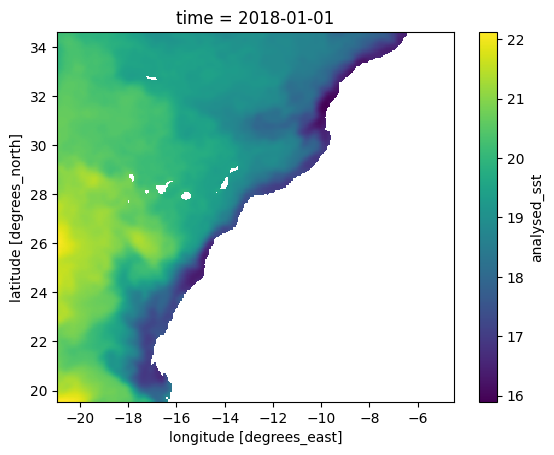

In [19]:
SST_SAT.isel(time=0)["analysed_sst"].plot()

In [20]:
# Load xarray dataset
REANALYS = copernicusmarine.open_dataset(dataset_id=reanalysis,
                                                     force_dataset_version="202311",
                                                     variables=["thetao"],
                                                     minimum_longitude=min_lon,
                                                     maximum_longitude=max_lon,
                                                     minimum_latitude=min_lat,
                                                     maximum_latitude=max_lat,
                                                     start_datetime=start_date,
                                                     end_datetime=end_date,
                                                     minimum_depth=0.49402499198913574,
                                                     maximum_depth=0.49402499198913574,
                                                     )


# Print loaded dataset information
REANALYS

WARNING - 2024-03-04T16:17:11Z - 'force_dataset_version' has been deprecated, use 'dataset_version' instead
INFO - 2024-03-04T16:17:11Z - You forced selection of dataset version "202311"
INFO - 2024-03-04T16:17:11Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-03-04T16:17:12Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 181, longitude: 198, time: 1096)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 19.58 19.67 19.75 19.83 ... 34.42 34.5 34.58
  * longitude  (longitude) float32 -20.92 -20.83 -20.75 ... -4.667 -4.583 -4.5
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

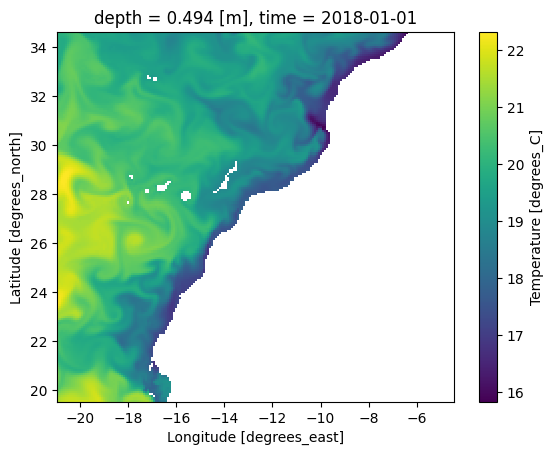

In [21]:
REANALYS.isel(time=0).isel(depth=0)["thetao"].plot()

## Resolution interpolation
---


In [52]:
# SST_SAT_resized = interpolation.resize_lonxlat(SST_SAT, (198, 181))
# SST_SAT_resized
SST_SAT_resized = SST_SAT.interp({'longitude': REANALYS['longitude'].data,
                                  'latitude': REANALYS['latitude'].data},
                                  method="linear")
SST_SAT_resized

<xarray.Dataset>
Dimensions:         (time: 1096, latitude: 181, longitude: 198)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
  * longitude       (longitude) float32 -20.92 -20.83 -20.75 ... -4.583 -4.5
  * latitude        (latitude) float32 19.58 19.67 19.75 ... 34.42 34.5 34.58
Data variables:
    analysed_sst    (time, latitude, longitude) float64 22.1 22.11 ... nan nan
    analysis_error  (time, latitude, longitude) float64 -273.0 -273.0 ... nan
Attributes: (12/34)
    Conventions:                CF-1.4
    cdm_data_type:              grid
    cmems_product_id:           cmems_SST_ATL_SST_L4_REP_OBSERVATIONS_010_026
    contact:                    emmanuelle.autret@ifremer.fr,jean.francois.pi...
    date_created:               20201113T102920Z
    easternmost_longitude:      12.98
    ...                         ...
    stop_time:                  19820101T120000Z
    summary:                    Sea Surface Temperature Analysis from the Eur...
    temporal_resolution:        daily
    title:                      European North West Shelf/Iberia Biscay Irish...
    uuid:                       
    westernmost_longitude:      -20.98

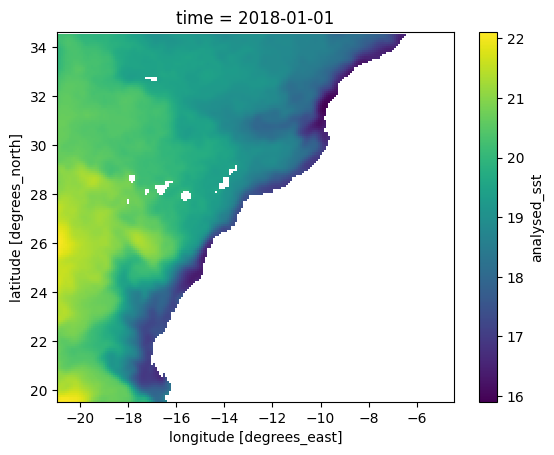

In [53]:
SST_SAT_resized["analysed_sst"].isel(time=0).plot()

In [12]:
# SST_SAT_resized.to_netcdf("C:\\Users\\gcuervo\\OneDrive - Universidad de Las Palmas de Gran Canaria\\Documents\\Doctorado\\DB\\GraphCast_data\\" 
#                            + "canarias_SST_Sat_198_181.nc")

## Satelite vs Reanalysis Difference
---

In [57]:
diff_reanalys_SatSST = REANALYS['thetao'].isel(depth=0) - SST_SAT_resized['analysed_sst']
diff_reanalys_SatSST

<xarray.DataArray (time: 1096, latitude: 181, longitude: 198)>
array([[[-0.56583379, -0.49360258, -0.42935028, ...,         nan,
                 nan,         nan],
        [-0.56747907, -0.49231817, -0.42769267, ...,         nan,
                 nan,         nan],
        [-0.56546783, -0.47903824, -0.41138649, ...,         nan,
                 nan,         nan],
        ...,
        [-0.28687825, -0.32809951, -0.35414988, ...,         nan,
                 nan,         nan],
        [-0.18759867, -0.22403132, -0.23570442, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.48020147, -0.40761104, -0.35616913, ...,         nan,
                 nan,         nan],
        [-0.47525495, -0.40448858, -0.34425761, ...,         nan,
                 nan,         nan],
        [-0.46811485, -0.38388443, -0.32062721, ...,         nan,
                 nan,         nan],
...
        [ 0.07851393,  0.08269643,  0.12787209, ...,         nan,
                 nan,         nan],
        [-0.03759988, -0.03311125,  0.00346565, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.35535723,  0.44116219,  0.48527641, ...,         nan,
                 nan,         nan],
        [ 0.30154508,  0.41185799,  0.47756774, ...,         nan,
                 nan,         nan],
        [ 0.21039963,  0.31880188,  0.43228531, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.11848191,  0.14785336,  0.2026502 , ...,         nan,
                 nan,         nan],
        [-0.03301201, -0.00604216,  0.06073952, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 19.58 19.67 19.75 19.83 ... 34.42 34.5 34.58
  * longitude  (longitude) float32 -20.92 -20.83 -20.75 ... -4.667 -4.583 -4.5
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31

In [71]:
# Filter January, April, July and October months
diff_reanalys_SatSST_JAJO = diff_reanalys_SatSST.isel(time=diff_reanalys_SatSST.time.dt.month.isin([1, 4, 7, 10]))
# Filter 1th of each month
diff_reanalys_SatSST_JAJO_D1 = diff_reanalys_SatSST_JAJO.isel(time=diff_reanalys_SatSST_JAJO.time.dt.day.isin([1]))
diff_reanalys_SatSST_JAJO_D1

<xarray.DataArray (time: 12, latitude: 181, longitude: 198)>
array([[[-0.56583379, -0.49360258, -0.42935028, ...,         nan,
                 nan,         nan],
        [-0.56747907, -0.49231817, -0.42769267, ...,         nan,
                 nan,         nan],
        [-0.56546783, -0.47903824, -0.41138649, ...,         nan,
                 nan,         nan],
        ...,
        [-0.28687825, -0.32809951, -0.35414988, ...,         nan,
                 nan,         nan],
        [-0.18759867, -0.22403132, -0.23570442, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.55217031,  0.54602623,  0.58690453, ...,         nan,
                 nan,         nan],
        [ 0.57093048,  0.5644132 ,  0.59642792, ...,         nan,
                 nan,         nan],
        [ 0.56508134,  0.58078232,  0.61386871, ...,         nan,
                 nan,         nan],
...
        [ 0.28717995,  0.28966192,  0.28766823, ...,         nan,
                 nan,         nan],
        [ 0.30976486,  0.30514456,  0.30042458, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.60082575,  0.56429901,  0.5065937 , ...,         nan,
                 nan,         nan],
        [ 0.43777042,  0.38916571,  0.32837289, ...,         nan,
                 nan,         nan],
        [ 0.3155124 ,  0.25280692,  0.19069672, ...,         nan,
                 nan,         nan],
        ...,
        [-0.23834078, -0.36180865, -0.41883799, ...,         nan,
                 nan,         nan],
        [-0.20345065, -0.32898331, -0.38771629, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    depth      float32 0.494
  * latitude   (latitude) float32 19.58 19.67 19.75 19.83 ... 34.42 34.5 34.58
  * longitude  (longitude) float32 -20.92 -20.83 -20.75 ... -4.667 -4.583 -4.5
  * time       (time) datetime64[ns] 2018-01-01 2018-04-01 ... 2020-10-01

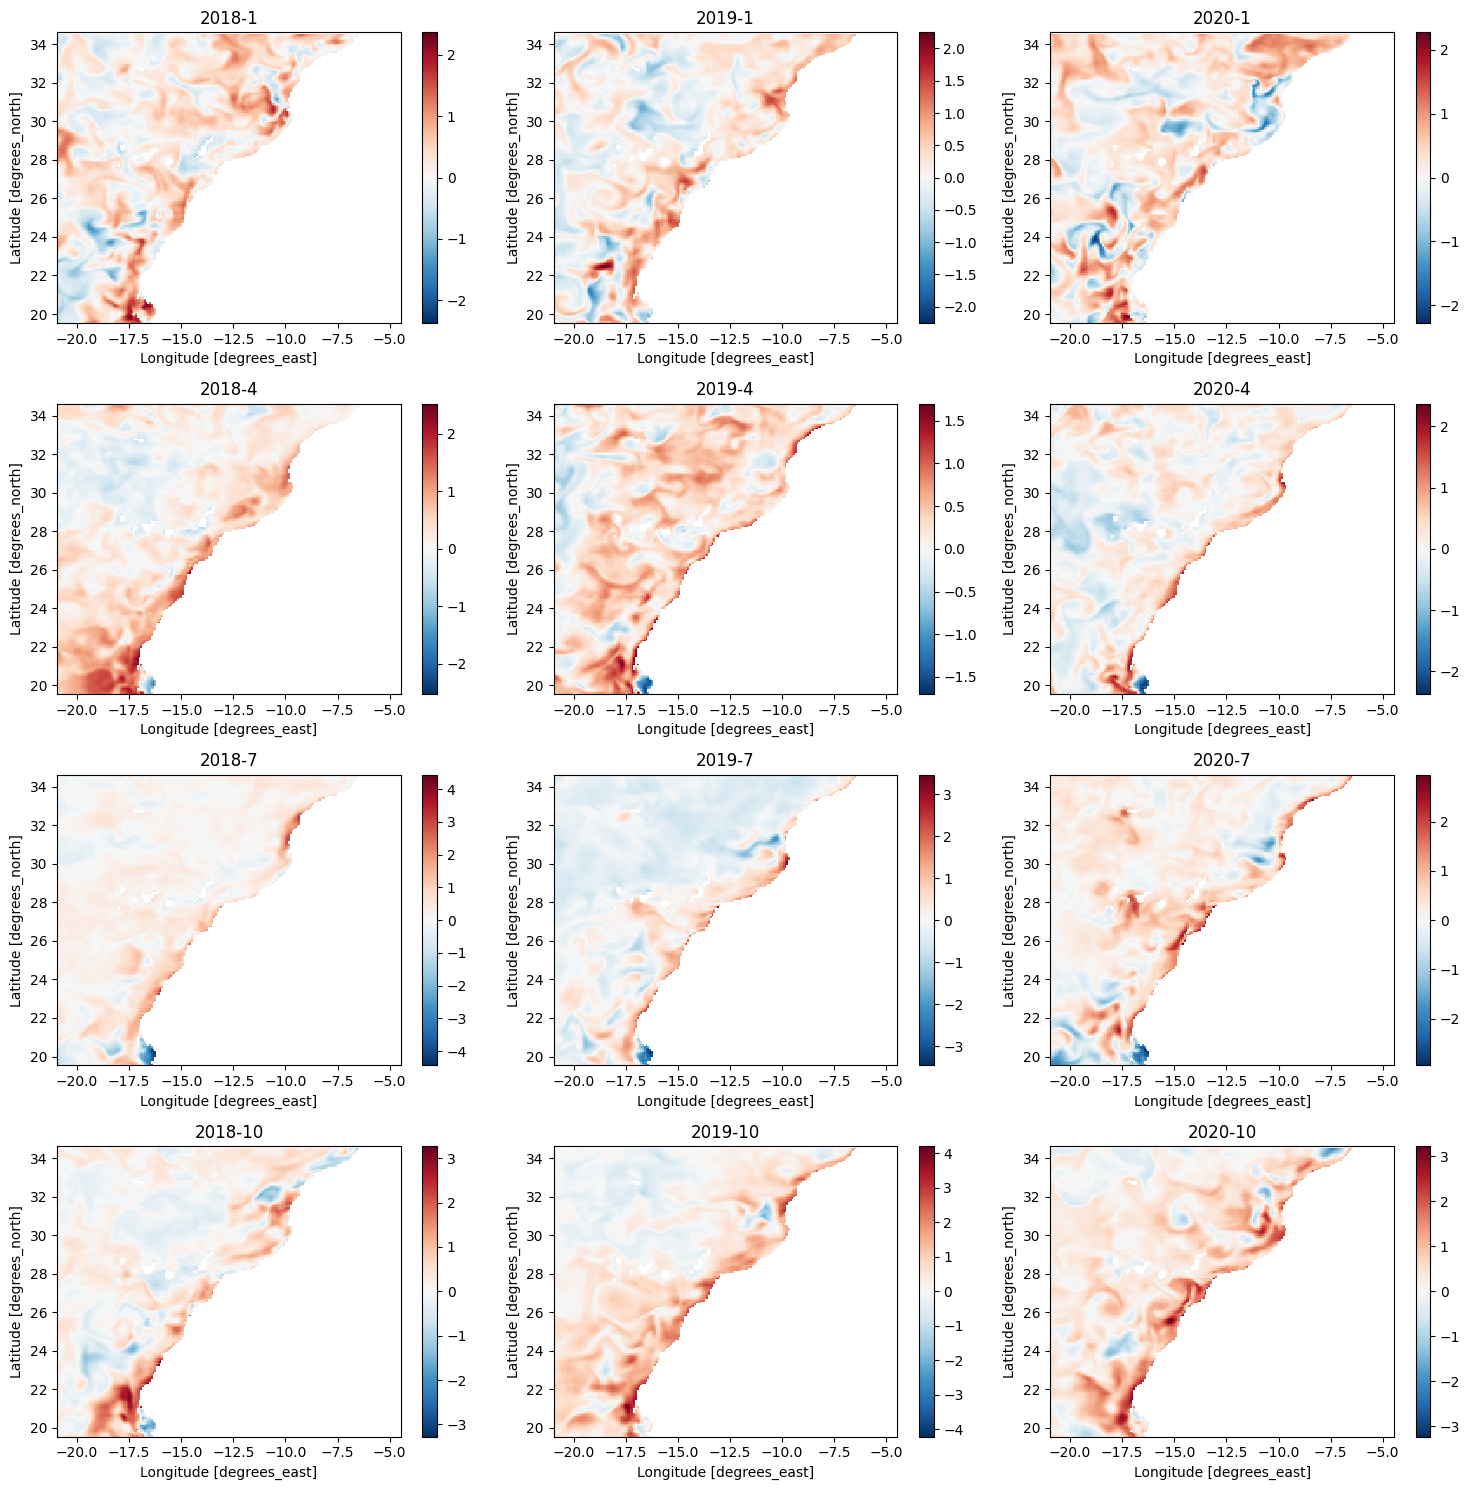

In [104]:
# Iterate over each subplot
years = diff_reanalys_SatSST_JAJO_D1['time.year'].data
months = diff_reanalys_SatSST_JAJO_D1['time.month'].data

# Create a grid of subplots
fig, axs = plt.subplots(len(set(months)), len(set(years)), figsize=(15, 15))

for i, month in enumerate(sorted(set(months))):
    for j, year in enumerate(sorted(set(years))):
        # Get the data for the corresponding month and year
        month_data = diff_reanalys_SatSST_JAJO_D1.sel(time=f'{year}-{month}')

        # Plot the data
        ax = axs[i, j]
        month_data.plot(ax=ax)
        ax.set_title(f'{year}-{month}')
# Show the plot
plt.tight_layout()

## Datos Boya de Las Palmas Este
---

### Datos de Puertos del Estado
---

In [26]:
buoy_dir = "C:\\Users\\gcuervo\\OneDrive - Universidad de Las Palmas de Gran Canaria\\Documents\\Doctorado\\DB\\Boyas\\"

data_buoy = pd.read_csv(buoy_dir + "15530_20214_1414_WATER_TEMP_19920502111152_20240228121152.csv", 
                        sep='\s+', header=1, usecols=range(6), 
                        names=['year', 'month', 'day', 'hour', 'Temp[ºC]', 'chanel'],
                        parse_dates={'datetime': ['year', 'month', 'day', 'hour']},
                        index_col='datetime'
                        )
data_buoy

,Temp[ºC],chanel
datetime,,
2014-01-21 11:00:00,19.0,3
2014-01-21 12:00:00,19.1,3
2014-01-21 15:00:00,19.1,3
2014-01-21 16:00:00,19.1,3
2014-01-21 17:00:00,19.1,3
...,...,...
2024-02-27 21:00:00,20.3,3
2024-02-27 22:00:00,20.2,3
2024-02-27 23:00:00,20.3,3


<Axes: title={'center': 'Temperature Time Series'}, xlabel='datetime'>

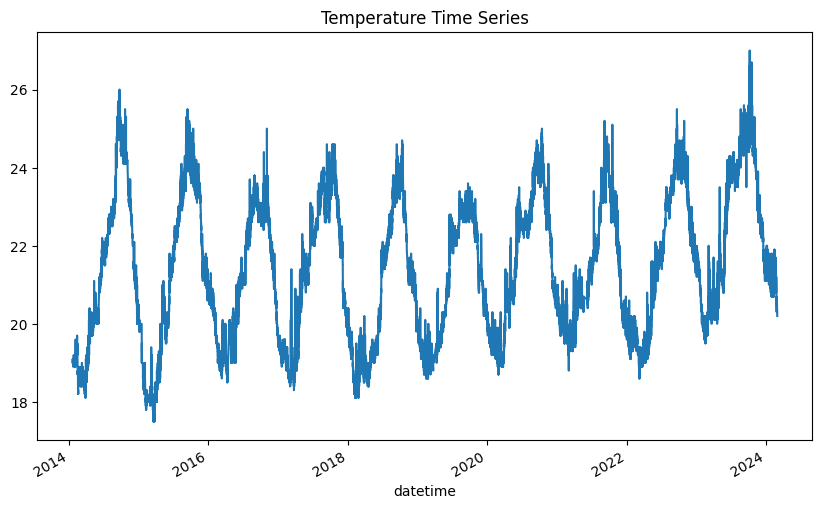

In [27]:
data_buoy['Temp[ºC]'].plot(figsize=(10, 6), title='Temperature Time Series')

### Datos de Copernicus in situ
---

In [28]:
data_buoy_nc = xr.open_dataset(buoy_dir + "IR_TS_MO_LasPalmas-coast-buoy.nc")['TEMP']
data_buoy_nc

<xarray.DataArray 'TEMP' (TIME: 257529, DEPTH: 2)>
[515058 values with dtype=float32]
Coordinates:
  * TIME               (TIME) datetime64[ns] 1992-02-05T16:00:00 ... 2024-01-...
    DEPH               (DEPTH) float32 ...
    STATION            |S64 ...
    LATITUDE           float32 ...
    LONGITUDE          float32 ...
    PRECISE_LATITUDE   (TIME) float32 ...
    PRECISE_LONGITUDE  (TIME) float32 ...
Dimensions without coordinates: DEPTH
Attributes:
    data_mode:            M
    long_name:            Sea temperature
    standard_name:        sea_water_temperature
    units:                degrees_C
    valid_max:            32.0
    valid_min:            -2.0
    ancillary_variables:  TEMP_QC TEMP_DM

In [29]:
coords_buoy_dict = {key: data_buoy_nc[key].data for key in data_buoy_nc.coords}
coords_buoy_dict

{'TIME': array(['1992-02-05T16:00:00.000000000', '1992-02-05T17:00:00.000000000',
        '1992-02-05T18:00:00.000000000', ...,
        '2024-01-31T21:00:00.000000000', '2024-01-31T22:00:00.000000000',
        '2024-01-31T23:00:00.000000000'], dtype='datetime64[ns]'),
 'DEPH': array([0. , 0.5], dtype=float32),
 'STATION': array(b'LasPalmas-coast-buoy                                            ',
       dtype='|S64'),
 'LATITUDE': array(28.05, dtype=float32),
 'LONGITUDE': array(-15.39, dtype=float32),
 'PRECISE_LATITUDE': array([28.05  , 28.05  , 28.05  , ..., 28.0531, 28.0531, 28.0531],
       dtype=float32),
 'PRECISE_LONGITUDE': array([-15.39  , -15.39  , -15.39  , ..., -15.3975, -15.3975, -15.3975],
       dtype=float32)}

In [30]:
lon_buoy, lat_buoy = coords_buoy_dict['LONGITUDE'].item(), coords_buoy_dict['LATITUDE'].item()
lon_buoy, lat_buoy

(-15.390000343322754, 28.049999237060547)

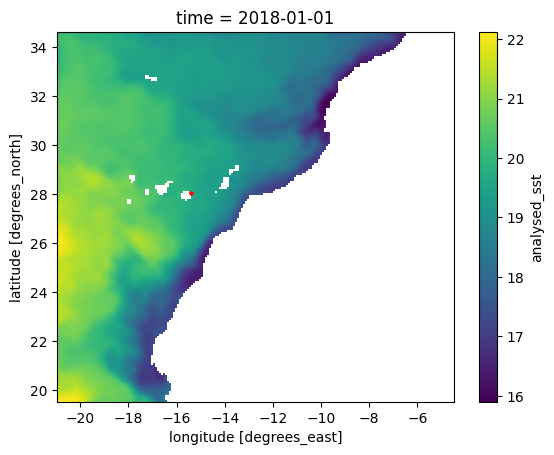

In [31]:
# Plot the point on the specified coordinates
SST_SAT_resized["analysed_sst"].isel(time=0).plot()
plt.scatter(lon_buoy, lat_buoy, color='red', label='Point', s=5)

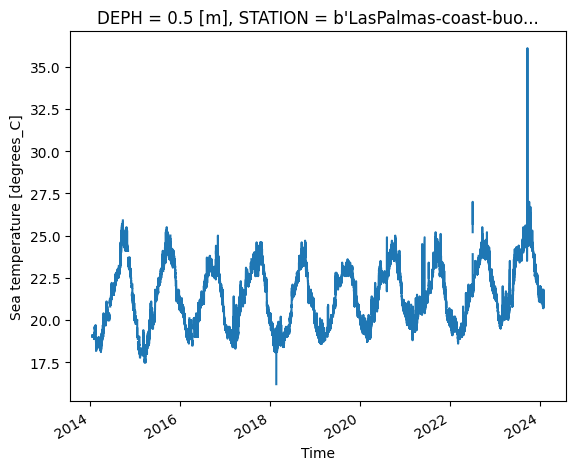

In [19]:
data_buoy_nc.isel(DEPTH=1).plot()

Los datos de Puertos del Estado están mejor al parecer ya han recibido tratamiento.

## Comparación
---

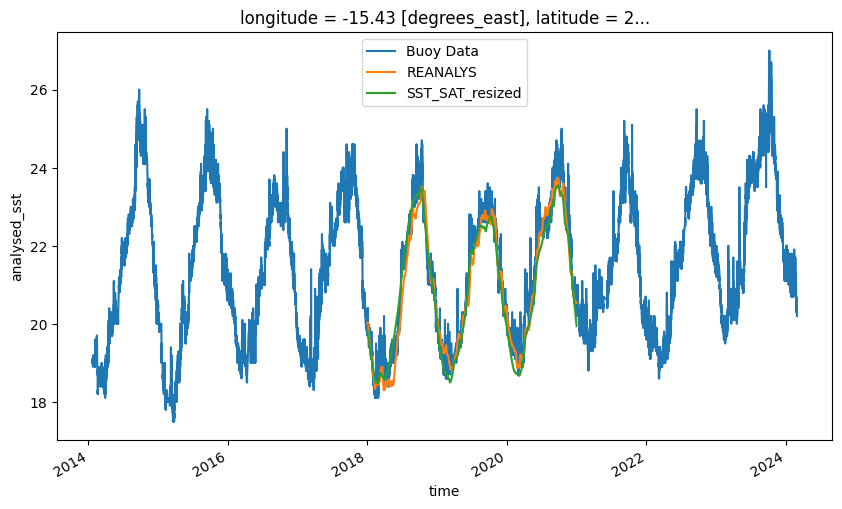

In [32]:
data_buoy['Temp[ºC]'].plot(figsize=(10, 6), title='Temperature Time Series', label='Buoy Data')
REANALYS.isel(depth=0).sel(latitude=lat_buoy, longitude=lon_buoy, 
                           method="nearest")["thetao"].plot(label='REANALYS')
SST_SAT_resized["analysed_sst"].sel(latitude=lat_buoy, longitude=lon_buoy, 
                                               method="nearest").plot(label='SST_SAT_resized')
# Add legend
plt.legend()

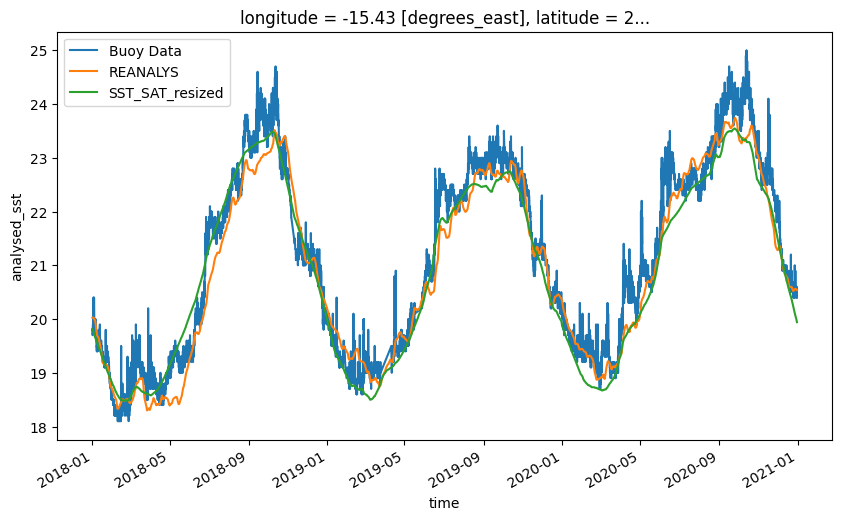

In [33]:
span_2018_2021 = (SST_SAT_resized["time"].data[0], SST_SAT_resized["time"].data[-1])
data_buoy[span_2018_2021[0]:span_2018_2021[-1]]['Temp[ºC]'].plot(figsize=(10, 6), 
                                                                 title='Temperature Time Series', 
                                                                 label='Buoy Data')
REANALYS.isel(depth=0).sel(latitude=lat_buoy, longitude=lon_buoy, 
                           method="nearest")["thetao"].plot(label='REANALYS')
SST_SAT_resized["analysed_sst"].sel(latitude=lat_buoy, longitude=lon_buoy, 
                                               method="nearest").plot(label='SST_SAT_resized')
# Add legend
plt.legend()

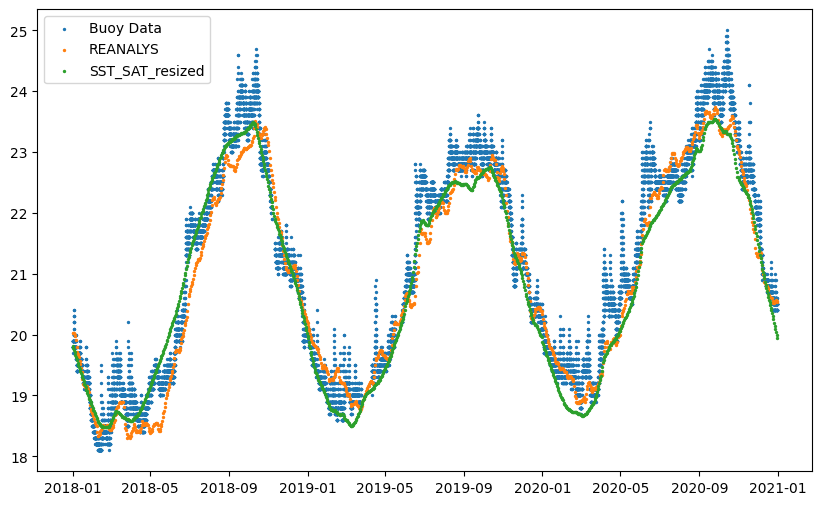

In [34]:
# Plot data_buoy with points
plt.figure(figsize=(10, 6))
marker_size = 2
plt.scatter(data_buoy[span_2018_2021[0]:span_2018_2021[-1]].index, 
            data_buoy[span_2018_2021[0]:span_2018_2021[-1]]['Temp[ºC]'], 
            label='Buoy Data', s=marker_size)

# Plot REANALYS with points
plt.scatter(REANALYS.sel(latitude=lat_buoy, longitude=lon_buoy, method="nearest")["time"].data, 
            REANALYS.isel(depth=0).sel(latitude=lat_buoy, longitude=lon_buoy, method="nearest")["thetao"], 
            label='REANALYS', s=marker_size)

# Plot SST_SAT_resized with points
plt.scatter(SST_SAT_resized.sel(latitude=lat_buoy, longitude=lon_buoy, method="nearest")["time"].data, 
            SST_SAT_resized["analysed_sst"].sel(latitude=lat_buoy, longitude=lon_buoy, method="nearest"), 
            label='SST_SAT_resized', s=marker_size)

# Add legend
plt.legend()

## Métricas de error
---
Considerando que los datos de la boya se registran con una resolución temporal de horas, es necesario promediarlos a nivel diario para equipararlos con la temporalidad de los datos satelitales y de reanálisis.

Sin embargo, durante ciertos días, **no se registraron datos** en la boya, según se observa en los registros. Por lo tanto, al realizar el promedio diario, estos días sin registros resultarán en valores **nulos**.

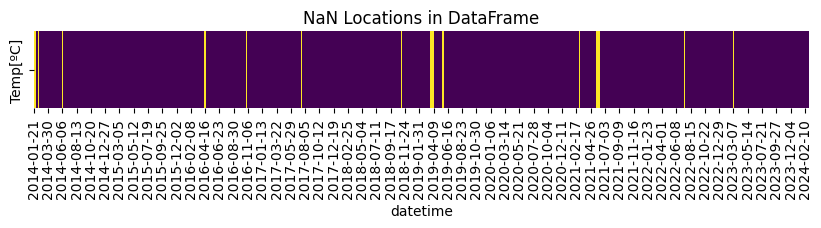

In [35]:
data_buoy_day = data_buoy['Temp[ºC]'].resample('D').mean()
# Use seaborn heatmap to visualize NaN locations
plt.figure(figsize=(10, 1))
sns.heatmap(pd.DataFrame(data_buoy_day.isna(), 
                         index=data_buoy_day.index.strftime('%Y-%m-%d')).T, 
            cmap='viridis', cbar=False)
plt.title('NaN Locations in DataFrame')
plt.show()

In [36]:
data_buoy_2018_2012_day = data_buoy_day[span_2018_2021[0]:span_2018_2021[-1]]
data_buoy_2018_2012_day

datetime
2018-01-01    19.839130
2018-01-02    19.970833
2018-01-03    19.958333
2018-01-04    19.883333
2018-01-05    19.831818
                ...    
2020-12-27    20.595652
2020-12-28    20.525000
2020-12-29    20.521739
2020-12-30    20.470833
2020-12-31    20.420833
Freq: D, Name: Temp[ºC], Length: 1096, dtype: float64

In [37]:
reanalys_df = (REANALYS.isel(depth=0)
               .sel(latitude=lat_buoy, longitude=lon_buoy, method="nearest")["thetao"]
               .to_pandas()
               )
reanalys_df

time
2018-01-01    20.026581
2018-01-02    20.028778
2018-01-03    20.020721
2018-01-04    19.998749
2018-01-05    19.974579
                ...    
2020-12-27    20.542955
2020-12-28    20.559801
2020-12-29    20.561998
2020-12-30    20.551012
2020-12-31    20.540758
Length: 1096, dtype: float32

In [38]:
SST_SAT_resized_Celsius = (SST_SAT_resized["analysed_sst"]
                           .sel(latitude=lat_buoy, longitude=lon_buoy, method="nearest")
                           .to_pandas()
                           )
SST_SAT_resized_Celsius

time
2018-01-01    19.816698
2018-01-02    19.776689
2018-01-03    19.746690
2018-01-04    19.706712
2018-01-05    19.666704
                ...    
2020-12-27    20.141102
2020-12-28    20.091114
2020-12-29    20.042241
2020-12-30    20.001118
2020-12-31    19.942235
Length: 1096, dtype: float64

Los valores nulos no influyen en el cálculo del RMSE, ya que cuando hay datos nulos, el error resultante también es nulo. Durante el cálculo de la media, estos valores nulos son descartados automáticamente.

In [39]:
def RMSE(est_data: pd.Series, obs_data: pd.Series) -> np.float64:
    squared_err = (est_data - obs_data)**2
    mse = squared_err.mean()
    return np.sqrt(mse)

In [40]:
RMSE(SST_SAT_resized_Celsius, data_buoy_2018_2012_day)


0.42051749695973556

In [41]:
RMSE(reanalys_df, data_buoy_2018_2012_day)

0.4250379495168162

In [42]:
RMSE(reanalys_df, SST_SAT_resized_Celsius)


0.36959151609462493